# **Netflix Stock Prediction using ARIMA Model**
We will be using a dataset that contains stock price values of Netflix from 2018 to 2022.
Here in this project our aim is to predict the stock price for the next 30 days using ARIMA Model.

# ***Analysis of dataset***
We have 7 columns in the dataset list as follows:
1. Date- Everyday price
2. Open- Price at which stock opened
3. High- Today's High
4. Low- Today's Low
5. Close- Close price adjusted for splits
6. Adj. Close- Adjusted close price adjusted for splits and dividend and/or capital gain distributions.
7. Volume- Volume of stocks

## ***We will start by importing required libraries.***

In [33]:
!pip install pmdarima

# ***Importing more libraries***

In [34]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX

# ***Reading the csv file***

In [35]:
df = pd.read_csv("/content/NFLX.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


# ***Deleting the irrelevant information by dropping the column corresponding to that data***

In [36]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df

,Date,Adj Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001
...,...,...
1004,2022-01-31,427.140015
1005,2022-02-01,457.130005
1006,2022-02-02,429.480011
1007,2022-02-03,405.600006


# ***Handling the missing values***

In [37]:
print (df.isna().sum())

Date         0
Adj Close    0
dtype: int64


# ***Matplotlib and Seaborn to create a probability distribution plot (histogram) and a quantile-quantile (QQ) plot for the 'Adj Close' column***

These plots help us understand the distribution of our data, make informed decisions about how to proceed with modeling, and detect potential issues like non-normality or outliers

<ipython-input-38-b814996cbe4e>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df['Adj Close'], fit=stats.norm)


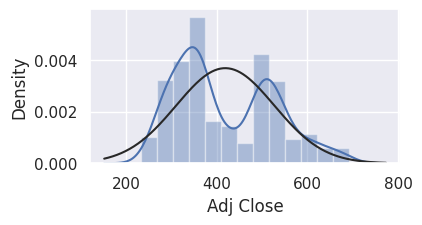

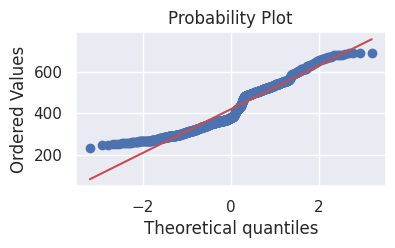

In [38]:
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
import pandas as pd

# Set the figure size
plt.figure(figsize=(4, 2))

# Create the distribution plot with a fitted normal curve
sb.distplot(df['Adj Close'], fit=stats.norm)

# Create the QQ-plot
fig, ax = plt.subplots()
stats.probplot(df['Adj Close'], plot=ax)

# Display the plots
plt.show()


# ***Aggregating and summarizing daily stock market data by calculating the sum of 'Adj Close' values for each unique date.***

In [39]:
df = df.groupby('Date')['Adj Close'].sum().reset_index()

# ***Converting the 'Date' column in the DataFrame df to a datetime format for better handling and analysis of time-based data.***

In [40]:
df.Date=pd.to_datetime(df.Date)
df

,Date,Adj Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001
...,...,...
1004,2022-01-31,427.140015
1005,2022-02-01,457.130005
1006,2022-02-02,429.480011
1007,2022-02-03,405.600006


# ***Setting the 'Date' column as the index of the DataFrame 'df' to enable time-based indexing and analysis.***

In [41]:
df = df.set_index('Date')
df.head()




,Adj Close
Date,
2018-02-05,254.259995
2018-02-06,265.720001
2018-02-07,264.559998
2018-02-08,250.100006
2018-02-09,249.470001


# ***Creating and displaying a plot of the DataFrame 'df' with a specified figure size of 20 inches in width and 5 inches in height using Matplotlib.***

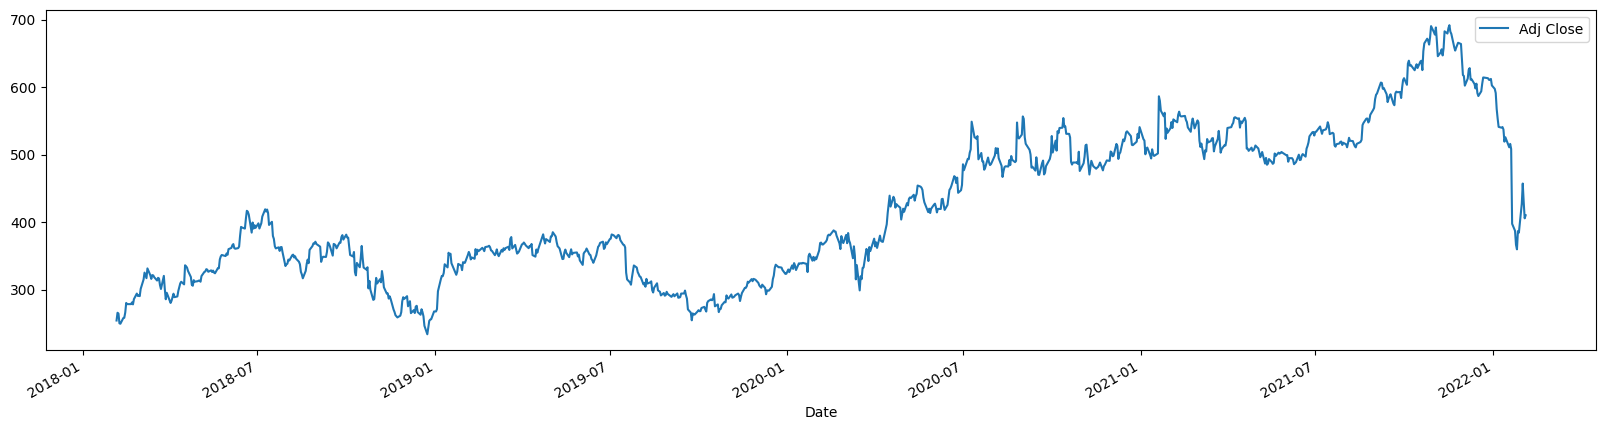

In [ ]:
df.plot(figsize=(20,5))
plt.show()

# ***Testing 'Adj Close' series for stationarity using ADF test.***
# ***ADF Test***
The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a given time series data is stationary or non-stationary.

In [48]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(time_series):
    result = adfuller(time_series)
    adf_statistic, p_value, lags_used, obs_used = result[:4]
    print(f'ADF Test Statistic: {adf_statistic:.6f}')
    print(f'p-value: {p_value:.6f}')
    print(f'#Lags Used: {lags_used}')
    print(f'#Observations Used: {obs_used}')

    if p_value <= 0.05:
        print('Strong evidence against null hypothesis; series is Stationary')
    else:
        print('Weak evidence against null hypothesis; series is not Stationary')

adfuller_test(df['Adj Close'])




ADF Test Statistic: -1.812591
p-value: 0.374229
#Lags Used: 6
#Observations Used: 1002
Weak evidence against null hypothesis; series is not Stationary


# ***Calculating first-order differences of the 'Adj Close' data and ploting the differenced data.***

ADF Test Statistic: -14.242276
p-value: 0.000000
#Lags Used: 5
#Observations Used: 1002
Strong evidence against null hypothesis; series is Stationary


<Axes: xlabel='Date'>

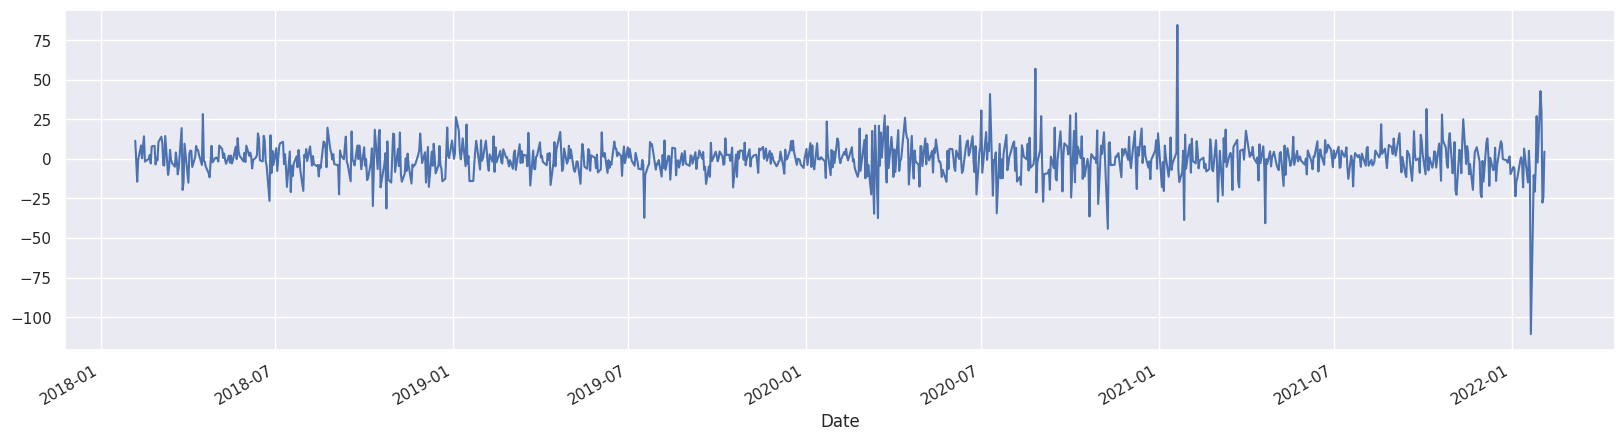

In [53]:
# Calculating first-order differences
diff1 = df['Adj Close'].diff().dropna()
adfuller_test(diff1)

# Plotting the differenced data
diff1.plot(figsize=(20, 5))


In [54]:
pip install statsmodels


# ***Plotting the Autocorrelation Function (ACF)***

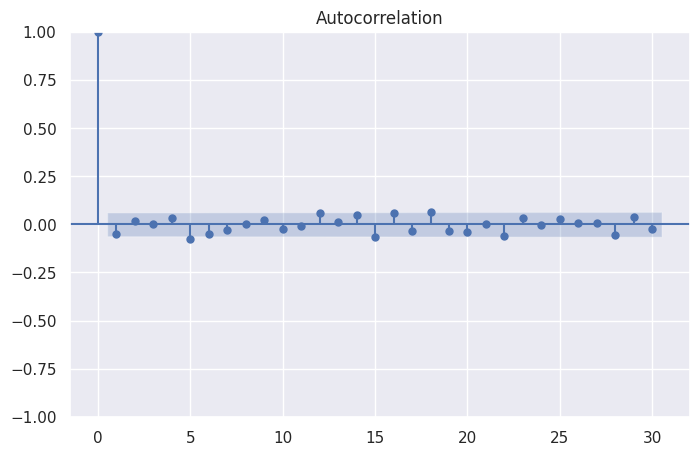

In [59]:
# Plotting the Autocorrelation Function (ACF)
fig, ax = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(diff1, ax=ax, lags=30)
plt.show()



# ***Plotting the Partial Autocorrelation Function (PACF)***

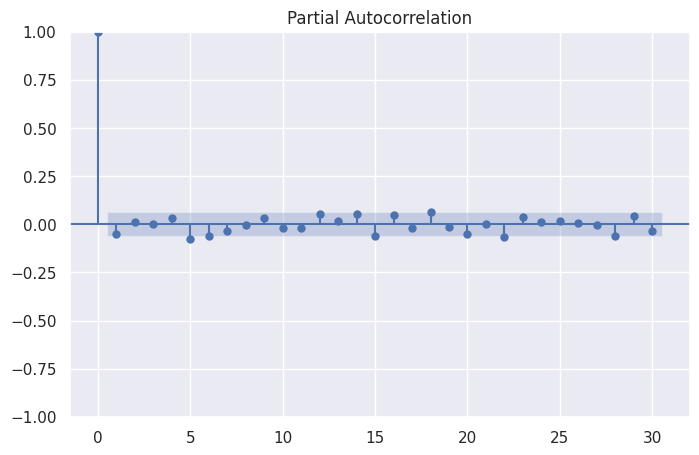

In [60]:
# Plotting the Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_pacf(diff1, ax=ax, lags=30)
plt.show()



# ***Fitting ARIMA models with different orders (p, d, q) and printing the AIC (Akaike Information Criterion)***

In [61]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

for p in range(1, 7):
    for q in range(1, 7):
        model = ARIMA(df['Adj Close'], order=(p, 0, q))
        result = model.fit()
        print(f"AIC: {result.aic:.2f}, AR Order: {p}, MA Order: {q}")


AIC: 7719.25, AR Order: 1, MA Order: 1
AIC: 7720.89, AR Order: 1, MA Order: 2
AIC: 7722.75, AR Order: 1, MA Order: 3
AIC: 7723.69, AR Order: 1, MA Order: 4
AIC: 7718.42, AR Order: 1, MA Order: 5
AIC: 7718.17, AR Order: 1, MA Order: 6
AIC: 7719.88, AR Order: 2, MA Order: 1
AIC: 7723.25, AR Order: 2, MA Order: 2
AIC: 7724.67, AR Order: 2, MA Order: 3
AIC: 7723.76, AR Order: 2, MA Order: 4
AIC: 7718.29, AR Order: 2, MA Order: 5
AIC: 7720.07, AR Order: 2, MA Order: 6
AIC: 7721.43, AR Order: 3, MA Order: 1
AIC: 7714.74, AR Order: 3, MA Order: 2
AIC: 7725.18, AR Order: 3, MA Order: 3
AIC: 7720.36, AR Order: 3, MA Order: 4
AIC: 7719.97, AR Order: 3, MA Order: 5
AIC: 7722.09, AR Order: 3, MA Order: 6
AIC: 7723.41, AR Order: 4, MA Order: 1
AIC: 7716.09, AR Order: 4, MA Order: 2
AIC: 7721.04, AR Order: 4, MA Order: 3
AIC: 7724.86, AR Order: 4, MA Order: 4
AIC: 7721.97, AR Order: 4, MA Order: 5
AIC: 7721.34, AR Order: 4, MA Order: 6
AIC: 7724.01, AR Order: 5, MA Order: 1
AIC: 7718.79, AR Order: 5

# ***Fitting an ARIMA(6,1,6) model to the 'Adj Close' data and displaying the model summary***

In [66]:
from statsmodels.tsa.arima.model import ARIMA

# Defining the order of the ARIMA model
order = (6, 1, 6)

# Fiting the ARIMA model
model = ARIMA(df['Adj Close'], order=order)
result = model.fit()

# Displaying the model summary
model_summary = result.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1009
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -3838.361
Date:                Sat, 28 Oct 2023   AIC                           7702.723
Time:                        20:54:51   BIC                           7766.627
Sample:                             0   HQIC                          7727.002
                               - 1009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2226      0.065      3.445      0.001       0.096       0.349
ar.L2          0.6265      0.062     10.131      0.000       0.505       0.748
ar.L3         -1.1327      0.069    -16.518      0.0

# ***Generating and plotting ARIMA(6,1,6) predictions for the 'Adj Close' data***

<Axes: xlabel='Date'>

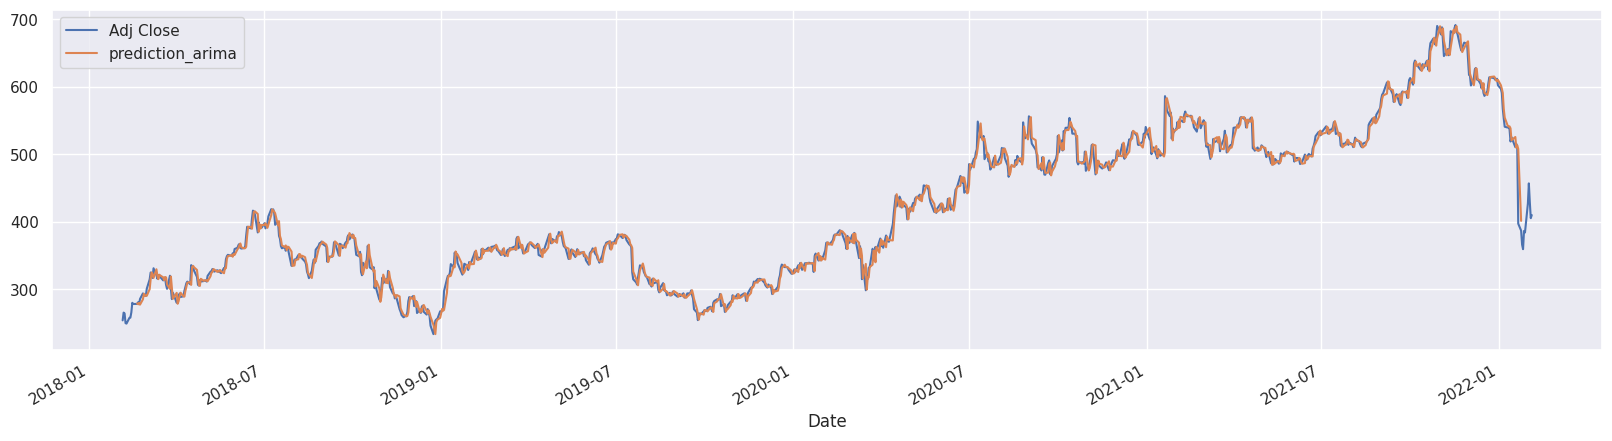

In [71]:
# Making ARIMA predictions
start = 10
end = 999
df['prediction_arima'] = result.predict(start=start, end=end)

# Plotting 'Adj Close' and ARIMA predictions
df[["Adj Close", "prediction_arima"]].plot(figsize=(20, 5))


# ***Generating a 30-day forecast with a 95% confidence level using the ARIMA(6,1,6) model and printing the rounded forecasted values***

In [72]:
# Generate 30-day forecasts with a confidence level of 95%
forecast = result.forecast(steps=30, alpha=0.05)

# Print the rounded forecasted values
for value in forecast:
    print(round(value, 0))



409.0
400.0
393.0
392.0
396.0
398.0
398.0
400.0
406.0
411.0
412.0
407.0
404.0
403.0
402.0
398.0
394.0
395.0
399.0
403.0
404.0
405.0
407.0
409.0
408.0
404.0
400.0
399.0
399.0
399.0


# ***Creating a pandas Series with forecast values and corresponding dates, based on the given forecast values and a specified date range***

In [73]:
fc = [408.0, 408.0, 407.0, 405.0, 411.0, 409.0, 410.0, 407.0, 407.0, 410.0, 409.0, 411.0, 407.0, 408.0, 409.0, 409.0, 410.0, 407.0, 409.0, 409.0, 410.0, 410.0, 408.0, 409.0, 408.0, 410.0, 409.0, 408.0, 409.0, 409.0]

# Create a date range from '2022-02-05' to '2022-03-06'
start_date = '2022-02-05'
end_date = '2022-03-06'
date_range = pd.date_range(start=start_date, end=end_date)


fc_with_dates = pd.Series(fc, index=date_range)
print(fc_with_dates)

2022-02-05    408.0
2022-02-06    408.0
2022-02-07    407.0
2022-02-08    405.0
2022-02-09    411.0
2022-02-10    409.0
2022-02-11    410.0
2022-02-12    407.0
2022-02-13    407.0
2022-02-14    410.0
2022-02-15    409.0
2022-02-16    411.0
2022-02-17    407.0
2022-02-18    408.0
2022-02-19    409.0
2022-02-20    409.0
2022-02-21    410.0
2022-02-22    407.0
2022-02-23    409.0
2022-02-24    409.0
2022-02-25    410.0
2022-02-26    410.0
2022-02-27    408.0
2022-02-28    409.0
2022-03-01    408.0
2022-03-02    410.0
2022-03-03    409.0
2022-03-04    408.0
2022-03-05    409.0
2022-03-06    409.0
Freq: D, dtype: float64


# ***Plotting the forecasted values with dates using a 20x5-inch figure size***

<Axes: >

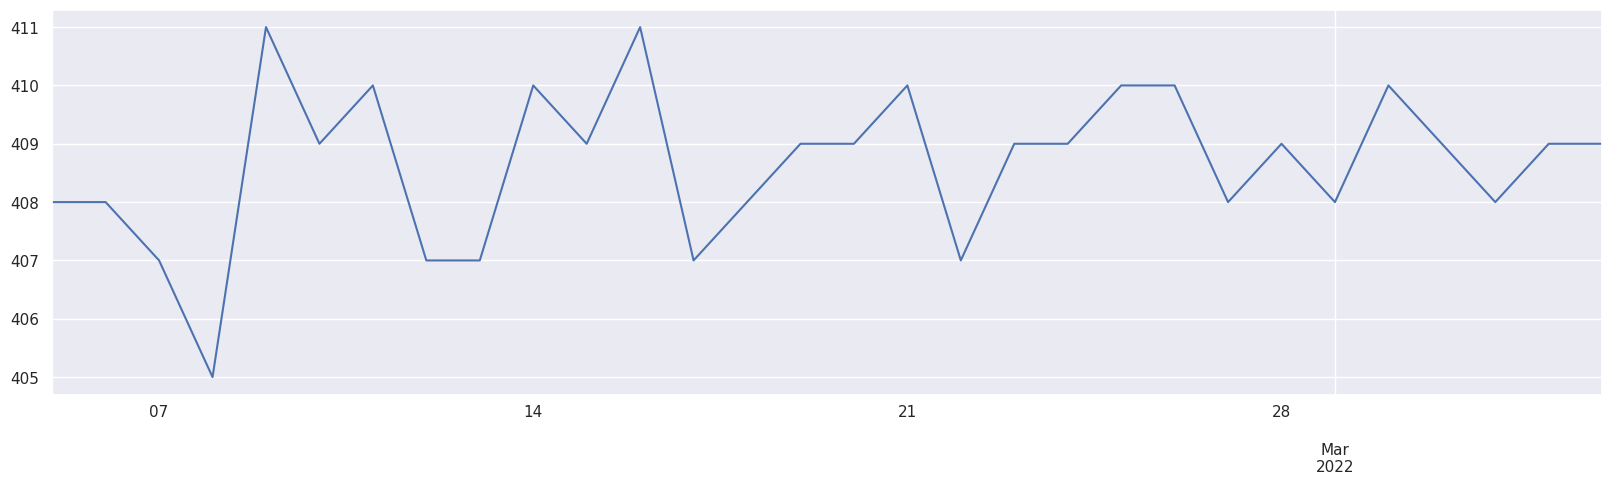

In [74]:
# Plotting the forecasted values with specified figure size
fc_with_dates.plot(figsize=(20, 5))


# ***Creating a plot with the 'Adj Close' data and forecasted values***

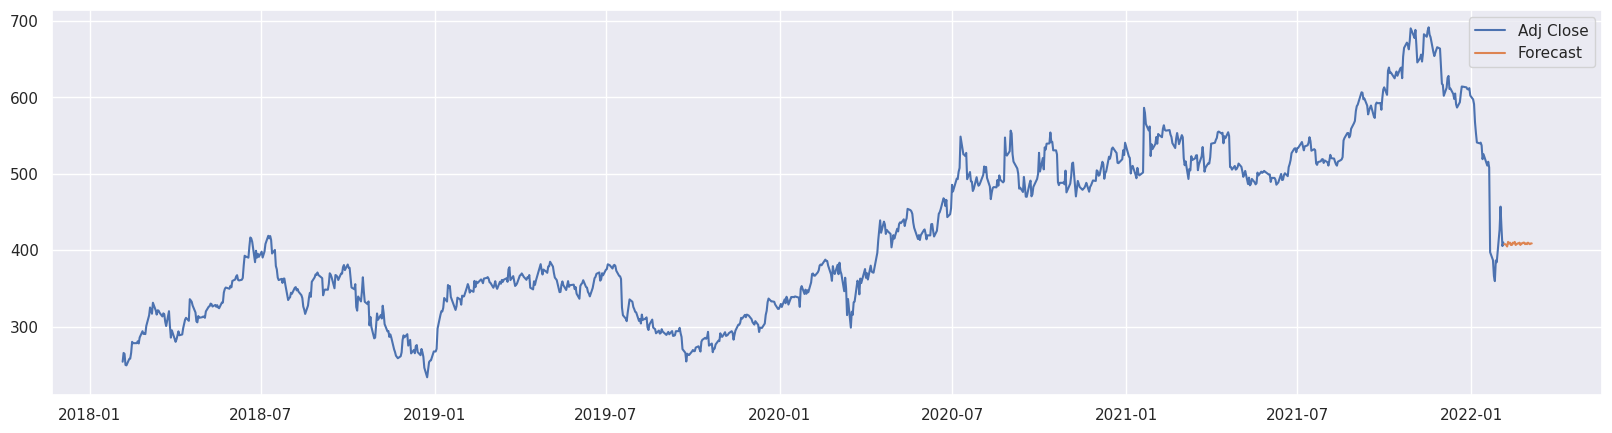

In [75]:
# Creating a figure and specify the figure size
plt.figure(figsize=(20, 5))

# Plotting the 'Adj Close' data
plt.plot(df["Adj Close"], label="Adj Close")

# Plotting the forecasted values with dates
plt.plot(fc_with_dates, label="Forecast")

# Adding a legend
plt.legend()

# Showing the plot
plt.show()


# **Conclusion**

In this analysis, I began by loading and preparing financial data, converting the 'Date' column to datetime format. Visual exploration revealed the distribution of the 'Adj Close' data, and I conducted statistical tests to assess its stationarity. The Augmented Dickey-Fuller (ADF) test confirmed that differencing was required to achieve stationarity. Autocorrelation and partial autocorrelation functions aided in selecting an ARIMA(6,1,6) model, which I fitted to the data. After assessing the model's goodness of fit using the Akaike Information Criterion (AIC), I used it to generate a 30-day forecast with a 95% confidence level. The results were visually presented by plotting the forecasted values alongside the historical 'Adj Close' data. This analysis aimed to provide insights into the stationarity of the time series, model selection, and short-term forecasts, which could inform investment decisions and financial strategies.